In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import string
import glob
from torch.utils.data import DataLoader
import shutil
import random
import os

from torchvision import datasets, transforms, models
import cv2 as cv
from torch import nn
from IPython.display import clear_output
from time import sleep
from PIL import Image
import json

**Loading dataset with dataloader**

---

In [2]:
# # Feature loading
dataset = '/kaggle/input/isl-fingerspell-composite'
train = dataset + '/train'
test = dataset + '/test'
valid = dataset + '/valid'

In [3]:
mean = [0.6507, 0.5438, 0.5606]
std = [0.1279, 0.1370, 0.1281]

training_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.GaussianBlur(11),
    transforms.RandomPerspective(distortion_scale=0.5,p =0.5),
    transforms.Resize(150),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

testing_transform = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [4]:
os.chdir('/kaggle/input/')
!ls

fingerspellclassification  isl-fingerspell-composite


In [5]:
train_dataset = datasets.ImageFolder(train, transform = training_transform)
test_dataset = datasets.ImageFolder(test, transform = testing_transform)
valid_dataset = datasets.ImageFolder(valid, transform = testing_transform)

In [6]:
train_loader = DataLoader(train_dataset, batch_size = 128  , shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 128  , shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size = 128  , shuffle=True)

In [7]:
# x,y = next(iter(train_loader))
# x = x.permute(1,0,2,3).reshape(3, 32*128*128)
# m = torch.mean(x, dim = 1)
# s = torch.std(x, dim = 1)
# print(m)
# print(s)
# print(x)

In [8]:

class_to_idx = train_dataset.class_to_idx
idx_to_class = {y:x for x,y in class_to_idx.items()}
len(class_to_idx)

37

In [9]:
# # i = 0
# # train_loader
# # for x,y in train_loader:
# #     print(idx_to_class[y[1].item()])
# #     print(x.shape)

# #     plt.imshow(x[1].permute(1,2,0))
# #     plt.show()
# #     sleep(2)
# #     break
# #     clear_output()
    
# for x,y in test_loader:
#     print(idx_to_class[y[1].item()])
#     print(x.shape)

#     plt.imshow(x[1].permute(1,2,0))
#     plt.show()
#     sleep(2)
#     break
#     clear_output()

In [10]:
# model_resnet = models.resnet50(pretrained = True)

# for param in model_resnet.parameters():
#     param.requires_grad = False

In [11]:
# model_resnet

In [12]:
# model_resnet.fc = nn.Sequential(
#     nn.Linear(in_features = 2048, out_features = 1000, bias=True),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.5),
#     nn.Linear(in_features = 1000, out_features = 500, bias=True),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.5),
#     nn.Linear(in_features = 500, out_features = 37, bias=True),
#     nn.LogSoftmax(dim=1)
# )

# for param in model_resnet.fc.parameters():
#     param.requires_grad = True

In [13]:
# model_resnet

In [14]:
def training(model, optimizer, model_path, epochs = 1):
    
    criterion = nn.NLLLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    train_acc_arr, val_acc_arr = ([], [])
    print("Training Started on ", device)
    last_val_acc = 0
    model = nn.DataParallel(model)
    for epoch in range(1, epochs+1):
        model = model.to(device)
        # train
        running_loss = 0
        correct_predictions = 0
        total_preds = 0
        step = 0
        model.train()   

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            logp = model.forward(x)
            loss = criterion(logp, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loge = torch.exp(logp)
            _, y_pred = loge.topk(1, dim=1)
            correct_predictions += torch.count_nonzero(y_pred.view(-1) == y).item()
            total_preds += x.shape[0]

            running_loss += loss.item()
            step += 1
            if step % 50 == 0:
                print(f"Training: Epoch : {epoch} Batch : {step} Loss : {loss.item()}")


        train_acc = (round(correct_predictions * 100 / total_preds, 2) if total_preds != 0 else "---")
        print(f"Training - Epoch : {epoch} Loss : {running_loss / len(train_loader)} accuracy : {train_acc}")
        train_acc_arr.append(train_acc)
        
        # validation check
        model.eval()
        running_loss = 0
        correct_predictions = 0
        total_preds = 0

        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                logp = model(x)
                loge = torch.exp(logp)
                _, y_pred = loge.topk(1, dim = 1)
                correct_predictions += torch.count_nonzero(y_pred.view(-1) == y).item()
                total_preds += x.shape[0]
                loss = criterion(logp, y)
                running_loss += loss.item()
        
        val_acc = (round(correct_predictions*100/total_preds, 2) if total_preds != 0 else "---")
        
        print(f"Validation - Epoch :{epoch} Loss : {running_loss/len(valid_loader)} accuracy : {val_acc}")
        val_acc_arr.append(val_acc)

            
        model  = model.to(torch.device('cpu'))
        checkpoint = {
        "model_state" : model.module.state_dict(),
        "optim_state" : optimizer.state_dict(),
        "classifier" : model.module.fc,
        "idx_to_class" : idx_to_class,
        }

        torch.save(checkpoint, model_path)
        
        if(last_val_acc-val_acc > 2):
            return;
        last_val = val_acc
    
    return train_acc_arr, val_acc_arr

In [15]:

# model_path = '/kaggle/working/model_resnet50.pth'
# optimizer = torch.optim.Adam(model_resnet.fc.parameters(), lr=0.001)
# training_accuracies, validation_accuracies = training(model_resnet, optimizer, model_path, epochs=1)

In [16]:
def load_model(model_path):
    checkpoint = torch.load(model_path, 'cpu')

    model = models.resnet50(weights=None)
    model.fc = checkpoint['classifier']
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0005)

    model.load_state_dict(checkpoint['model_state'])
    idx_to_class = checkpoint['idx_to_class']

    return model,optimizer

model_path = '/kaggle/input/fingerspellclassification/pytorch/best_model_finger_spell/1/model_resnet50.pth'
model, optimizer = load_model(model_path)
ta, va = training(model, optimizer,'/kaggle/working/model_resnet50.pth', epochs = 50)
prev_accuracies = json.load(open('/kaggle/input/fingerspellclassification/pytorch/best_model_finger_spell/1/accuracies.json', 'r'))
training_accuracies =   ta + prev_accuracies['training_accuracies']
validation_accuracies =  va + prev_accuracies['validation_accuracies']

json.dump({'training_accuracies':training_accuracies, 'validation_accuracies':validation_accuracies}, open('/kaggle/working/accuracies.json', 'w'))

Training Started on  cuda
Training: Epoch : 1 Batch : 50 Loss : 0.6843787431716919
Training: Epoch : 1 Batch : 100 Loss : 0.8583697080612183
Training: Epoch : 1 Batch : 150 Loss : 0.5953540205955505
Training: Epoch : 1 Batch : 200 Loss : 0.7575023770332336
Training - Epoch : 1 Loss : 0.6880428994740915 accuracy : 78.57
Validation - Epoch :1 Loss : 0.2356170319222115 accuracy : 92.89
Training: Epoch : 2 Batch : 50 Loss : 0.6352046728134155
Training: Epoch : 2 Batch : 100 Loss : 0.5209093689918518
Training: Epoch : 2 Batch : 150 Loss : 0.5975853204727173
Training: Epoch : 2 Batch : 200 Loss : 0.6903384327888489
Training - Epoch : 2 Loss : 0.6805999741094921 accuracy : 78.71
Validation - Epoch :2 Loss : 0.22667968353709658 accuracy : 93.12
Training: Epoch : 3 Batch : 50 Loss : 0.5570970773696899
Training: Epoch : 3 Batch : 100 Loss : 0.8639757037162781
Training: Epoch : 3 Batch : 150 Loss : 0.6974108815193176
Training: Epoch : 3 Batch : 200 Loss : 0.6652385592460632
Training - Epoch : 3 L

In [17]:
# model_vgg.eval()
# x,y = next(iter(test_loader))
# x,y = x.to(torch.device('cuda')), y.to(torch.device('cuda'))
# op = model_vgg(x)
# op = torch.exp(op)
# _, y_pred = op.topk(1, dim = 1)
# print(y)
# print(idx_to_class[y_pred])

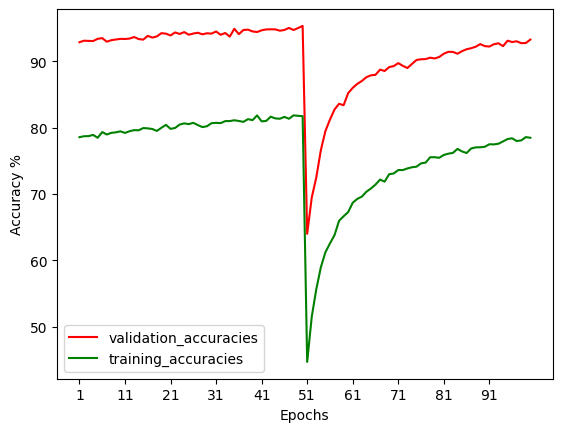

In [18]:
import matplotlib.pyplot as plt

n_epochs = len(validation_accuracies)

plt.plot( range(1, n_epochs + 1), validation_accuracies, color = 'red')
plt.plot(range(1, n_epochs + 1),  training_accuracies, color = 'green')

plt.legend(['validation_accuracies','training_accuracies'])
plt.xlabel('Epochs')
plt.xticks(range(1, n_epochs+1, n_epochs//10))
plt.ylabel('Accuracy %')
plt.show()

In [19]:

# rchannel = torch.tensor([])
# gchannel = torch.tensor([])
# bchannel = torch.tensor([])

# for file in glob.glob('/kaggle/input/isl-fingerspell-composite/*/*/*'):
#     img = Image.open(file)
#     transform = transforms.Compose([transforms.ToTensor()])
#     tensor_img = transform(img)
#     tensor_img = tensor_img.reshape(3,-1)
#     rchannel = torch.cat((rchannel, tensor_img[0]), 0)
#     gchannel = torch.cat((gchannel, tensor_img[1]), 0)
#     bchannel = torch.cat((bchannel, tensor_img[2]), 0)

In [20]:
# mean = [torch.mean(rchannel).item(), torch.mean(gchannel).item(), torch.mean(bchannel).item()]
# std = [torch.std(rchannel).item(), torch.std(gchannel).item(), torch.std(bchannel).item()]

In [21]:
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
acc_arr = []
truths = []
preds = []
with torch.no_grad():
    for x,y in test_loader:
        x, y = x.to(device), y.to(device)
        log_pred = model(x)
        pred = torch.exp(log_pred)
        prob, cl = pred.topk(1)
        preds += cl.flatten()
        truths += y
        acc = ((cl.flatten() == y).count_nonzero().item()/len(y))
        acc_arr.append(acc)
acc_arr[:10]

[0.953125,
 0.953125,
 0.9609375,
 0.984375,
 0.9375,
 0.96875,
 0.9765625,
 0.9375,
 0.9765625,
 0.9765625]

In [22]:
np.mean(acc_arr)

0.952982305936073

In [23]:
preds = [p.item() for p in preds]
truths = [p.item() for p in truths]
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(truths, preds)
cf

array([[493,   0,   0, ...,   0,   0,   0],
       [  0, 399,   0, ...,   0,   0,   0],
       [  0,   0,   1, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 165,   2,   4],
       [  0,   0,   0, ...,   4, 182,   3],
       [  0,   0,   0, ...,   0,   1, 194]])

In [24]:

labels = [idx_to_class[i] for i in range(cf.shape[0])]
plt.figure(figsize=(20,20), dpi=800)


sb.heatmap(cf, xticklabels = labels, yticklabels = labels, annot=True,fmt='.0f', square = True, cbar=False)
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.title("Confusion Matrix for ISL prediction Rensnet")
plt.show()